In [3]:
### imports

# external modules
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import importlib
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.models import Model, Sequential, load_model
import importlib

# local modules
sys.path.append('../utils')
import csv_utils as csvu
import json_utils as jsonu
import dataframe_utils as dfu
import hist_utils as hu
import autoencoder_utils as aeu
import plot_utils as pu
import generate_data_utils as gdu
import refruns_utils as rru
importlib.reload(csvu)
importlib.reload(jsonu)
importlib.reload(dfu)
importlib.reload(hu)
importlib.reload(aeu)
importlib.reload(pu)
importlib.reload(gdu)
importlib.reload(rru)
sys.path.append('../src')
sys.path.append('../src/classifiers')
sys.path.append('../src/cloudfitters')
import HistStruct
importlib.reload(HistStruct)
import SubHistStruct
importlib.reload(SubHistStruct)
import DataLoader
importlib.reload(DataLoader)
import AutoEncoder
importlib.reload(AutoEncoder)
import SeminormalFitter
import GaussianKdeFitter
import HyperRectangleFitter
importlib.reload(SeminormalFitter)
importlib.reload(GaussianKdeFitter)
importlib.reload(HyperRectangleFitter)

<module 'HyperRectangleFitter' from '/eos/home-i01/k/khowey/SWAN_projects/ML4DQMDC-PixelAE/KH-AutoencoderTest/../src/cloudfitters/HyperRectangleFitter.py'>

In [4]:
### Speed Controls and Run Mode

# Disables all plots for large datasets where speed is more important
createPlots = True

# Control for the notebook - turn off user-friendly mode to enable faster runtimes
userfriendly = True

In [5]:
### Data Controls and Selection - 1D Autoncoder

# The directory data is located in
datadir = '../data/'

# Select a list of good runs to train on in development training_mode
# Should be validated by eye
trainrunsls = {'2017':{
                    "297057":[[-1]], 
                    "297099":[[-1]], 
                    "297101":[[-1]],
                    "297113":[[-1]], 
                    "297114":[[-1]], 
                    "297175":[[-1]],
                    "297177":[[-1]],
                    "297179":[[-1]], 
                    "297215":[[-1]],
                    "297218":[[-1]],
                    "297225":[[-1]],
                    "297296":[[-1]], 
                    "297411":[[-1]],
                    "297426":[[-1]],
                    "297431":[[-1]],
                    "297434":[[-1]],
                    "297468":[[-1]],
                    "297483":[[-1]],
                    "297486":[[-1]],
                    "297503":[[-1]],
                    "297557":[[-1]],
                    "297598":[[-1]],
                    "297604":[[-1]],
                    "297620":[[-1]], 
                    "297659":[[-1]],
                    "297670":[[-1]],
                    "297674":[[-1]],
                    "297678":[[-1]], 
                    "297722":[[-1]],
                    "298997":[[-1]],
                    "299061":[[-1]],
                    "299065":[[-1]], 
                    "299067":[[-1]],
                    "299096":[[-1]],
                    "299149":[[-1]],
                    "299178":[[-1]], 
                    "299184":[[-1]],
                    "299185":[[-1]],
                    "299327":[[-1]],
                    "299329":[[-1]], 
                    "299480":[[-1]]
                    },
              '2018':{ # needs to be re-checked, not guaranteed to be fully correct or representative.   
                  "315267":[[-1]] 
              }
}


badrunsls = {'2017':
                {
                    #"297048":[[-1]],
                    #"297282":[[-1]],
                    #"297283":[[-1]],
                    #"297284":[[-1]],
                    #"297287":[[-1]],
                    #"297288":[[-1]],
                    #"297289":[[-1]],
                    #"299316":[[-1]],
                    #"299317":[[-1]],
                    #"299318":[[-1]],
                    #"299324":[[-1]],
                    "299326":[[-1]],
                    #"301086":[[88,126]],
                    #"301086":[[89,89]],
                    #"303948":[[1710,1710]],
                    #"297047":[[-1]], #close but, true bad for all 8
                    #"297169":[[-1]], #true bad for all 8
#                   "297211":[[-1]], #Reconstructs well
#                   "299325":[[-1]], #Reconstructs well
#                    "297664":[[-1]], #true bad for all 8
#                    "299317":[[-1]], #true bad for all 8
#                    "297169":[[-1]], #true bad for all 8
#                    "297502":[[-1]]
                },
            '2018': # needs to be re-checked, not guaranteed to be fully correct or representative.
                {
                #"317479":[[-1]],
                "317480":[[-1]],
                "317481":[[-1]],
                "317482":[[-1]],
                #"319847":[[1,35]]
            }}


# The year and eras being used
year = '2017'
eras = ['B']

# Create a list of histograms to include
# Pair histograms to be combined on the same line
histnames = [
#    ['NormalizedHitResiduals_TIB__Layer__1', 'Summary_ClusterStoNCorr__OnTrack__TIB__layer__1', 'NormalizedHitResiduals_TIB__Layer__2', 'Summary_ClusterStoNCorr__OnTrack__TIB__layer__2',
#     'NormalizedHitResiduals_TIB__Layer__3', 'Summary_ClusterStoNCorr__OnTrack__TIB__layer__3' , 'NormalizedHitResiduals_TIB__Layer__4', 'Summary_ClusterStoNCorr__OnTrack__TIB__layer__4'],
    ['chargeInner_PXLayer_1','chargeOuter_PXLayer_1'],
    ['chargeInner_PXLayer_2', 'chargeOuter_PXLayer_2'],
#    ['chargeInner_PXLayer_3', 'chargeOuter_PXLayer_3'],
#    ['chargeInner_PXLayer_4', 'chargeOuter_PXLayer_4'],
#    ['charge_PXDisk_+1', 'charge_PXDisk_-1'],
#    ['charge_PXDisk_+2', 'charge_PXDisk_-2'],
#    ['charge_PXDisk_+3', 'charge_PXDisk_-3'],
#    ['NormalizedHitResiduals_TOB__Layer__1', 'Summary_ClusterStoNCorr__OnTrack__TOB__layer__1', 'NormalizedHitResiduals_TOB__Layer__2', 'Summary_ClusterStoNCorr__OnTrack__TOB__layer__2',
#     'NormalizedHitResiduals_TOB__Layer__3', 'Summary_ClusterStoNCorr__OnTrack__TOB__layer__3' , 'NormalizedHitResiduals_TOB__Layer__4', 'Summary_ClusterStoNCorr__OnTrack__TOB__layer__4']
]

# Read new data or use previously saved data & should data be saved
readnew = True
save = False

In [6]:
### Define Run Properties - Combined Autoencoder
# in this cell all major run properties are going to be set,

# Set whether to train globally or locally or in a development/testing mode
training_mode = 'development'

# Selects whether to create a new histstruct or use a saved one
readnew = True

# Select whether to save a new histstruct
save = False

In [7]:
### Model Controls and Selection - 1D Autoencoder

plotNames = 'Test'
name = plotNames+'plots'

# Choose whether to train a new model or load one
trainnew = True
savemodel = True
modelname = plotNames

# Evaluate models seperately, as an ensemble, both, or neither
individualEval = True
ensembleEval = False

In [10]:
dloader = DataLoader.DataLoader()
histstruct = SubHistStruct.SubHistStruct()
histstruct.reset_histlist(histnames)

# Unpack histnames and add every histogram individually
for histnamegroup in histnames:
    for histname in histnamegroup:
        print('Adding {}...'.format(histname))
        
        # Bring the histograms into memory from storage for later use
        filename = '../data/DF'+year+'B_'+histname+'.csv'
        df = dloader.get_dataframe_from_file( filename )

Adding chargeInner_PXLayer_1...
Adding chargeOuter_PXLayer_1...
Adding chargeInner_PXLayer_2...
Adding chargeOuter_PXLayer_2...


297057
Histogram for chargeInner_PXLayer_1


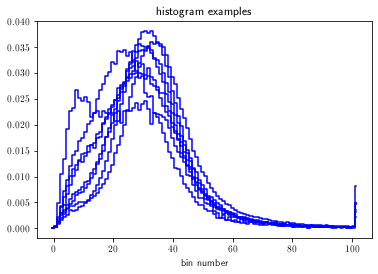


Histogram for chargeOuter_PXLayer_1


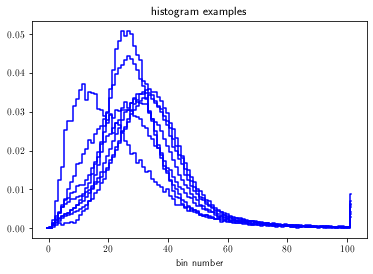


Histogram for chargeInner_PXLayer_2


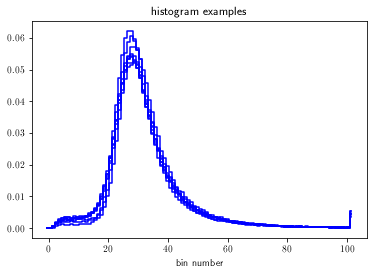


Histogram for chargeOuter_PXLayer_2


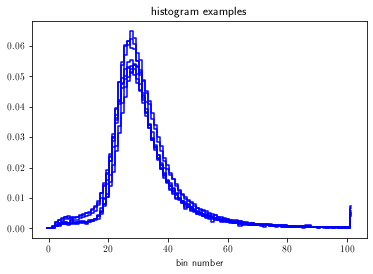


297099
Histogram for chargeInner_PXLayer_1


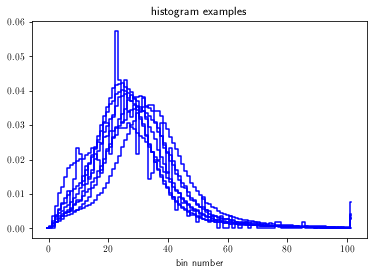


Histogram for chargeOuter_PXLayer_1


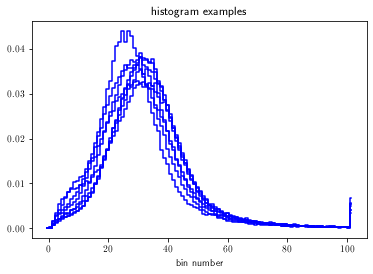


Histogram for chargeInner_PXLayer_2


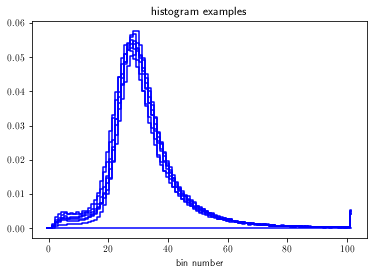


Histogram for chargeOuter_PXLayer_2


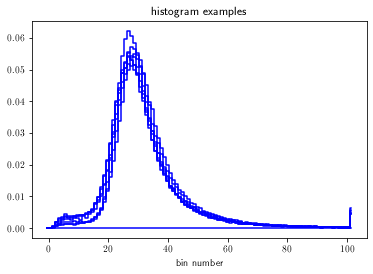


297101
Histogram for chargeInner_PXLayer_1


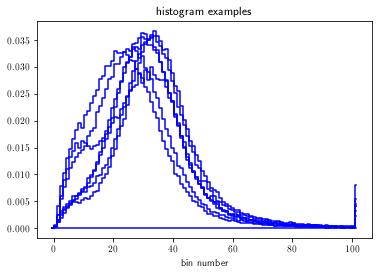


Histogram for chargeOuter_PXLayer_1


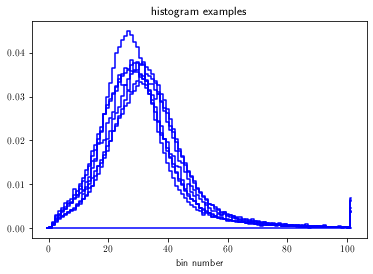


Histogram for chargeInner_PXLayer_2


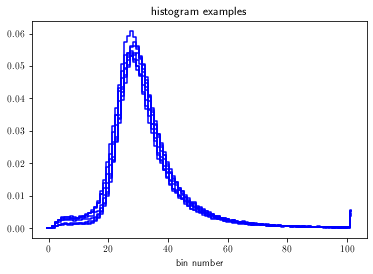


Histogram for chargeOuter_PXLayer_2


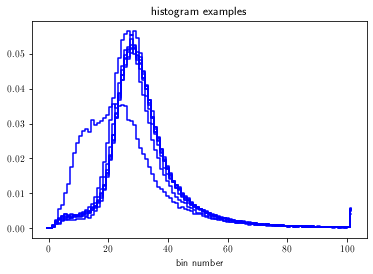


297113
Histogram for chargeInner_PXLayer_1


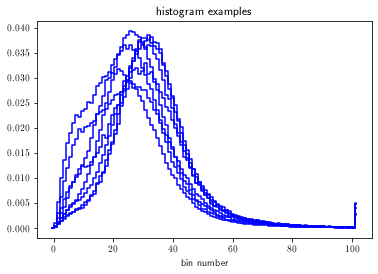


Histogram for chargeOuter_PXLayer_1


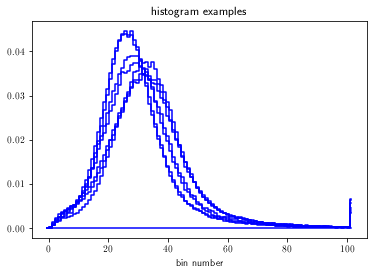


Histogram for chargeInner_PXLayer_2


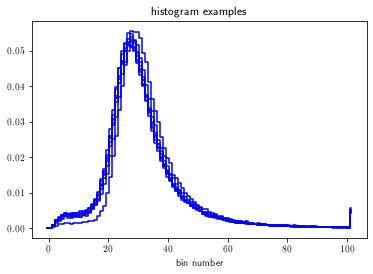


Histogram for chargeOuter_PXLayer_2


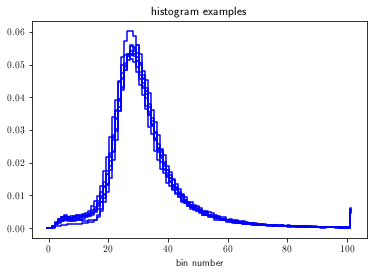


297114
Histogram for chargeInner_PXLayer_1


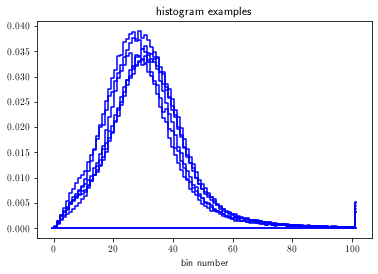


Histogram for chargeOuter_PXLayer_1


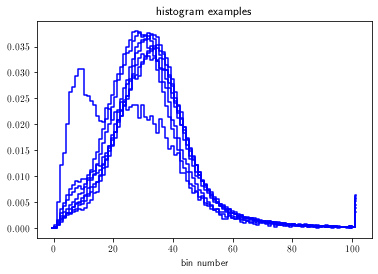


Histogram for chargeInner_PXLayer_2


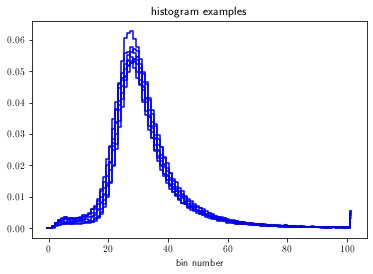


Histogram for chargeOuter_PXLayer_2


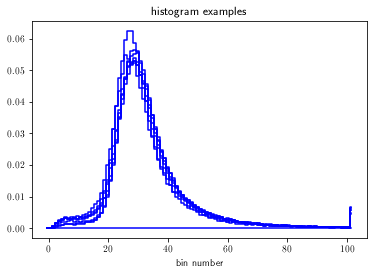


297175
Histogram for chargeInner_PXLayer_1


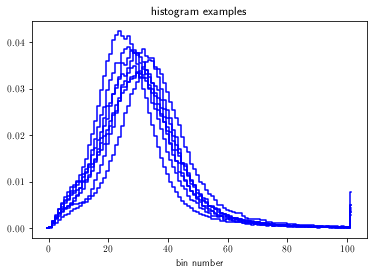


Histogram for chargeOuter_PXLayer_1


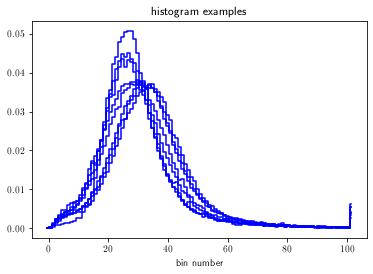


Histogram for chargeInner_PXLayer_2


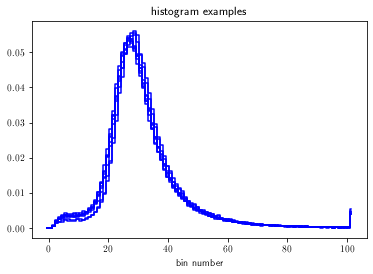


Histogram for chargeOuter_PXLayer_2


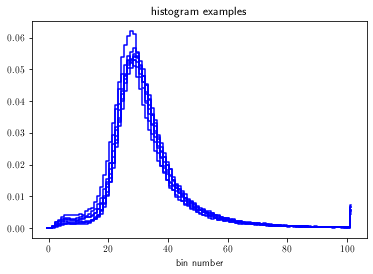


297177
Histogram for chargeInner_PXLayer_1


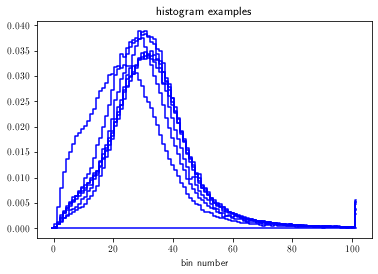


Histogram for chargeOuter_PXLayer_1


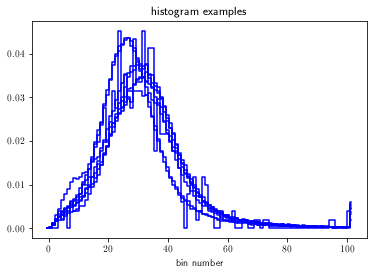


Histogram for chargeInner_PXLayer_2


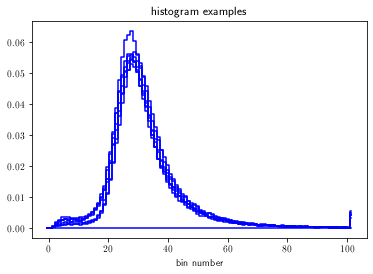


Histogram for chargeOuter_PXLayer_2


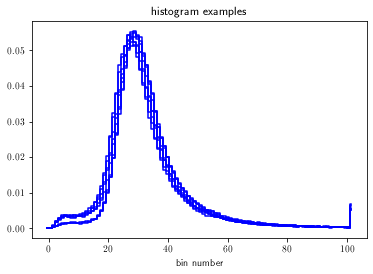


297179
Histogram for chargeInner_PXLayer_1


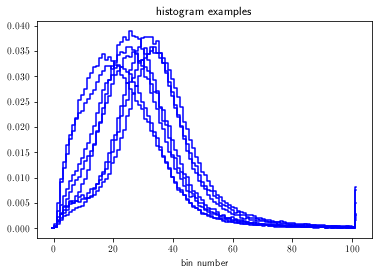


Histogram for chargeOuter_PXLayer_1


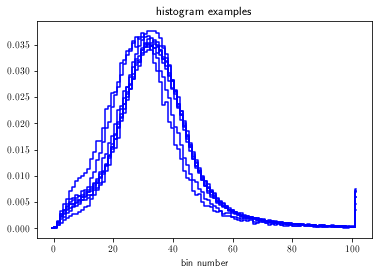


Histogram for chargeInner_PXLayer_2


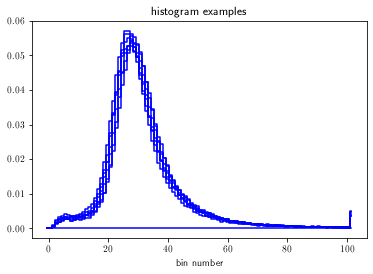


Histogram for chargeOuter_PXLayer_2


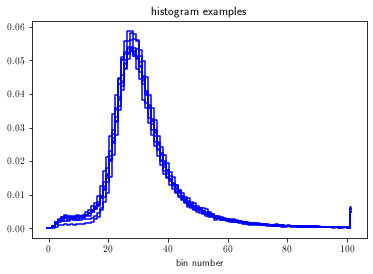


297215
Histogram for chargeInner_PXLayer_1


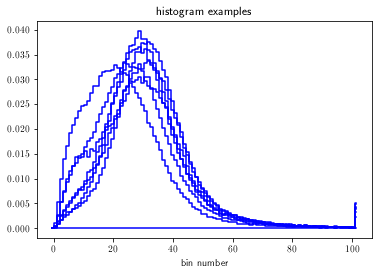


Histogram for chargeOuter_PXLayer_1


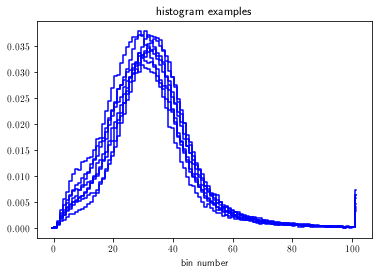


Histogram for chargeInner_PXLayer_2


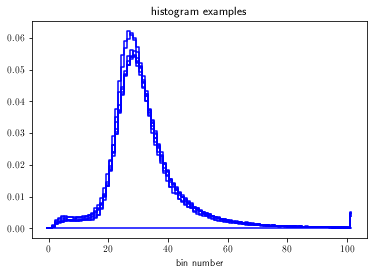


Histogram for chargeOuter_PXLayer_2


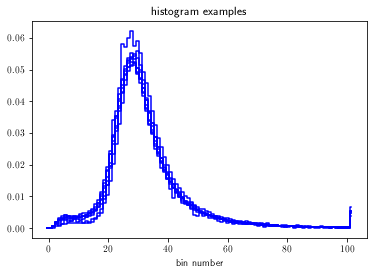


297218
Histogram for chargeInner_PXLayer_1


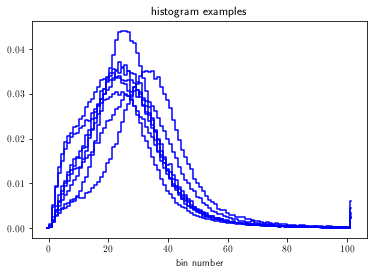


Histogram for chargeOuter_PXLayer_1


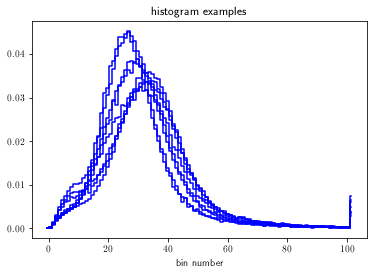


Histogram for chargeInner_PXLayer_2


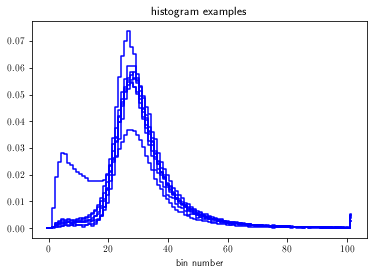


Histogram for chargeOuter_PXLayer_2


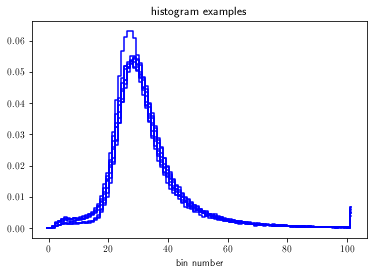


297225
Histogram for chargeInner_PXLayer_1


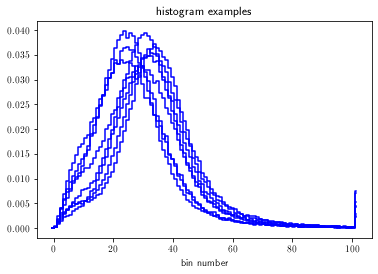


Histogram for chargeOuter_PXLayer_1


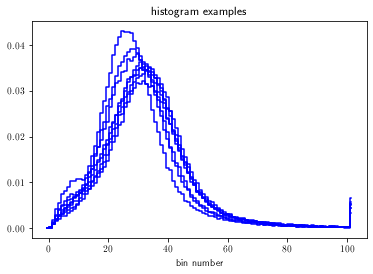


Histogram for chargeInner_PXLayer_2


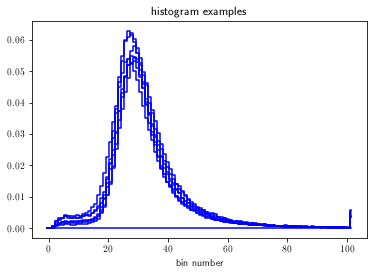


Histogram for chargeOuter_PXLayer_2


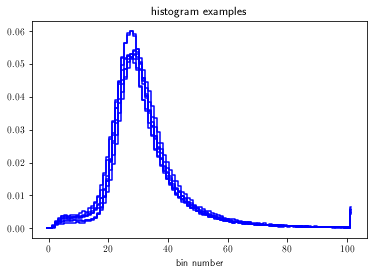


297296
Histogram for chargeInner_PXLayer_1


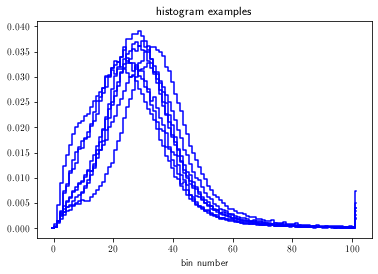


Histogram for chargeOuter_PXLayer_1


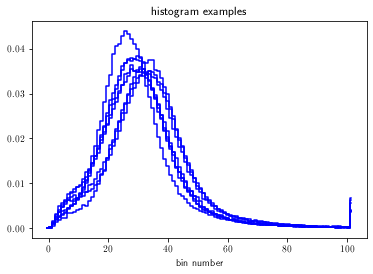


Histogram for chargeInner_PXLayer_2


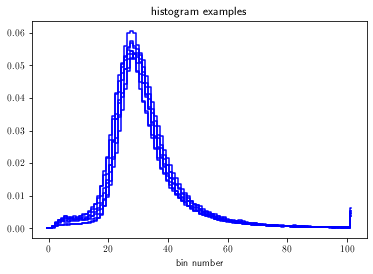


Histogram for chargeOuter_PXLayer_2


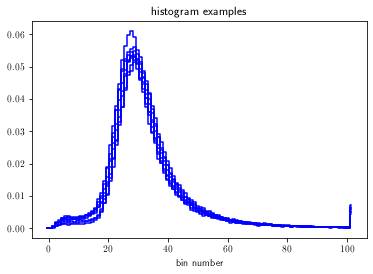


297411
Histogram for chargeInner_PXLayer_1


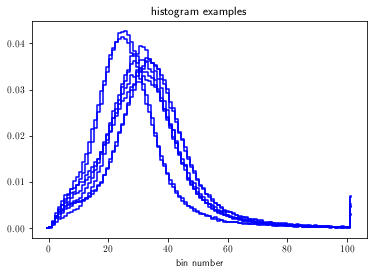


Histogram for chargeOuter_PXLayer_1


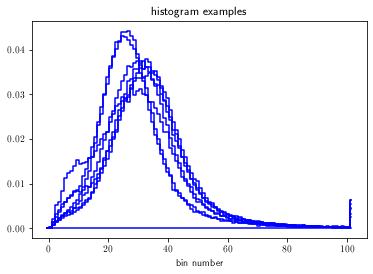


Histogram for chargeInner_PXLayer_2


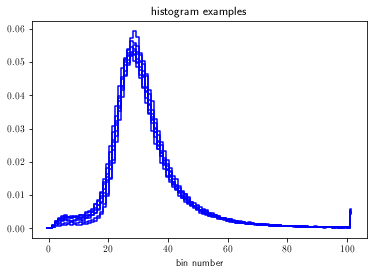


Histogram for chargeOuter_PXLayer_2


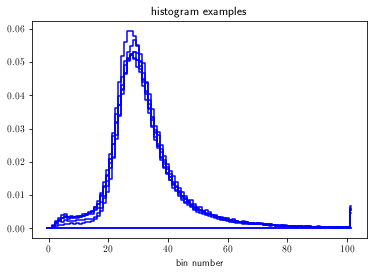


297426
Histogram for chargeInner_PXLayer_1


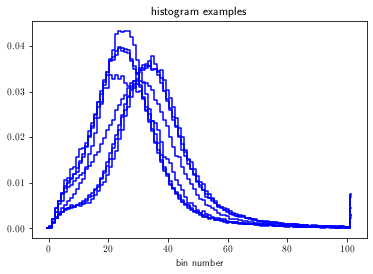


Histogram for chargeOuter_PXLayer_1


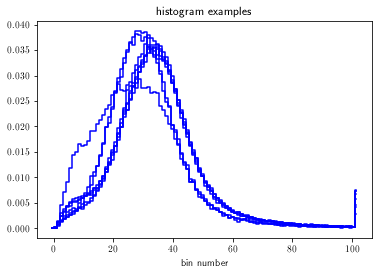


Histogram for chargeInner_PXLayer_2


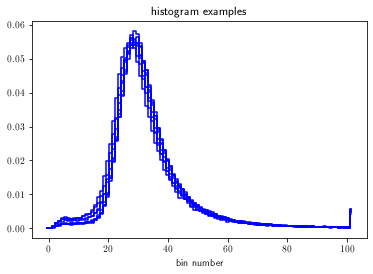


Histogram for chargeOuter_PXLayer_2


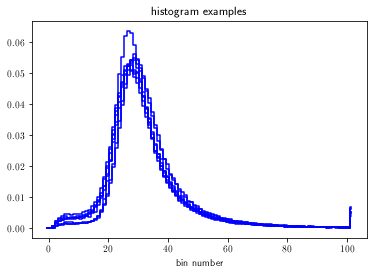


297431
Histogram for chargeInner_PXLayer_1


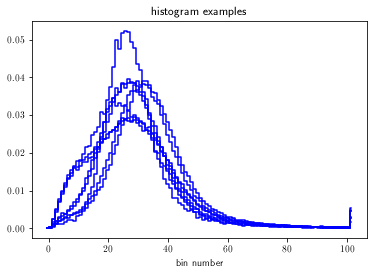


Histogram for chargeOuter_PXLayer_1


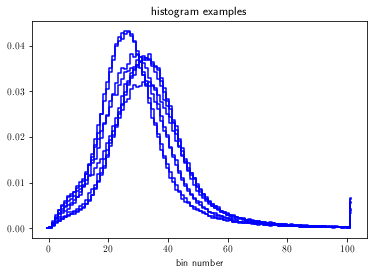


Histogram for chargeInner_PXLayer_2


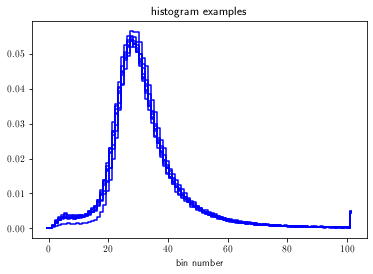


Histogram for chargeOuter_PXLayer_2


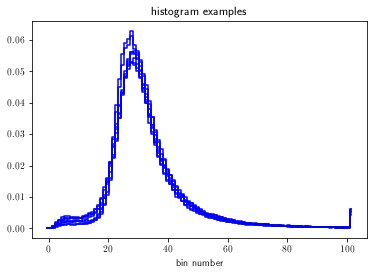


297434
Histogram for chargeInner_PXLayer_1


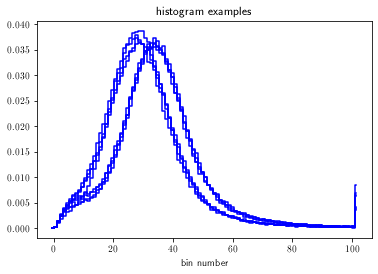


Histogram for chargeOuter_PXLayer_1


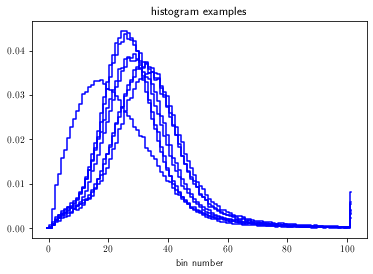


Histogram for chargeInner_PXLayer_2


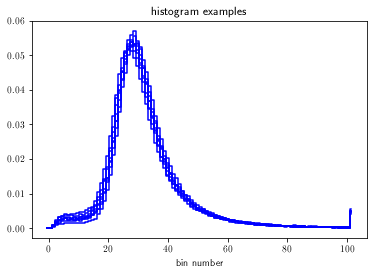


Histogram for chargeOuter_PXLayer_2


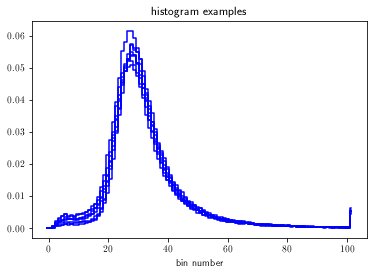


297468
Histogram for chargeInner_PXLayer_1


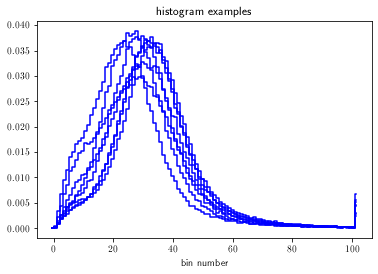


Histogram for chargeOuter_PXLayer_1


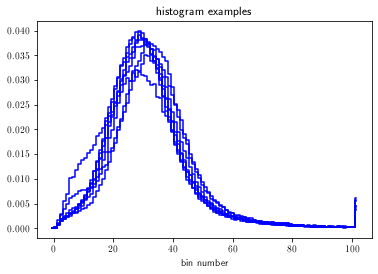


Histogram for chargeInner_PXLayer_2


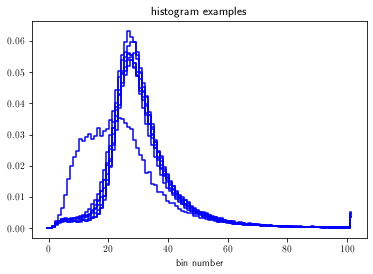


Histogram for chargeOuter_PXLayer_2


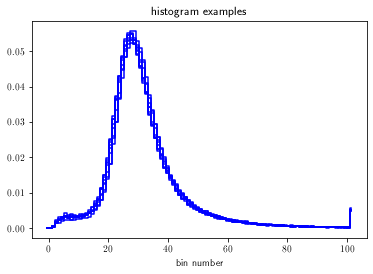


297483
Histogram for chargeInner_PXLayer_1


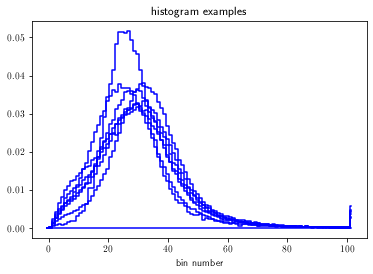


Histogram for chargeOuter_PXLayer_1


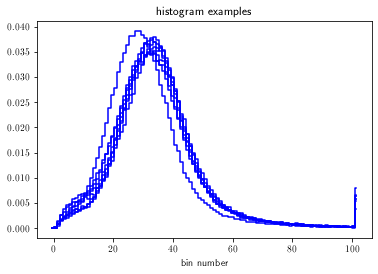


Histogram for chargeInner_PXLayer_2


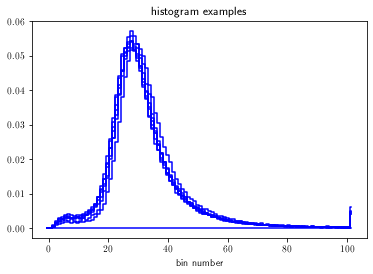


Histogram for chargeOuter_PXLayer_2


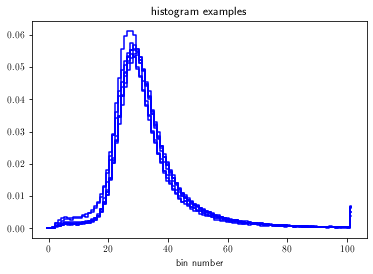


297486
Histogram for chargeInner_PXLayer_1


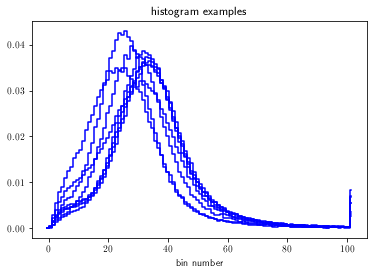


Histogram for chargeOuter_PXLayer_1


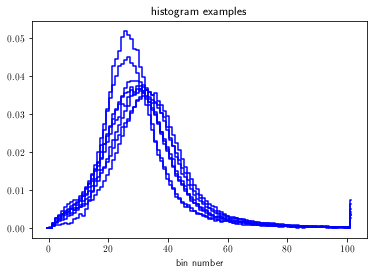


Histogram for chargeInner_PXLayer_2


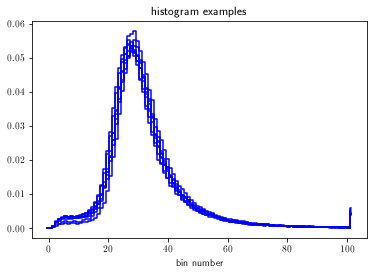


Histogram for chargeOuter_PXLayer_2


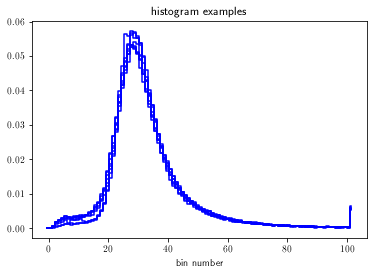


297503
Histogram for chargeInner_PXLayer_1


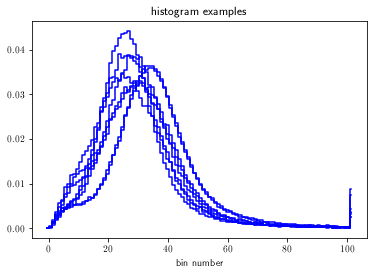


Histogram for chargeOuter_PXLayer_1


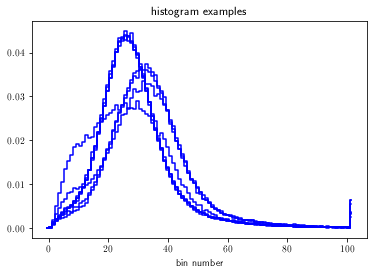


Histogram for chargeInner_PXLayer_2


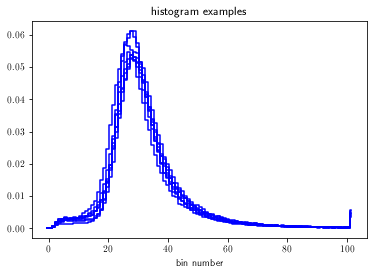


Histogram for chargeOuter_PXLayer_2


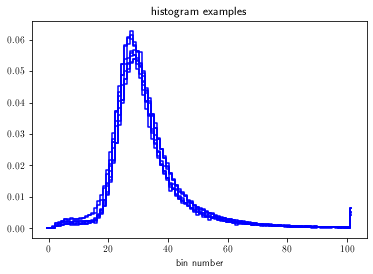


297557
Histogram for chargeInner_PXLayer_1


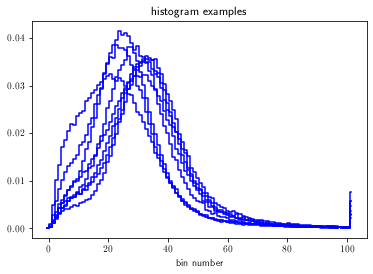


Histogram for chargeOuter_PXLayer_1


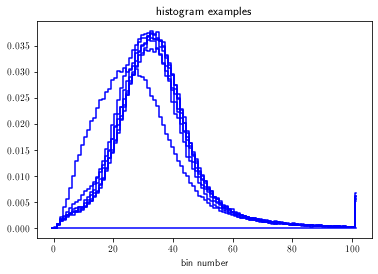


Histogram for chargeInner_PXLayer_2


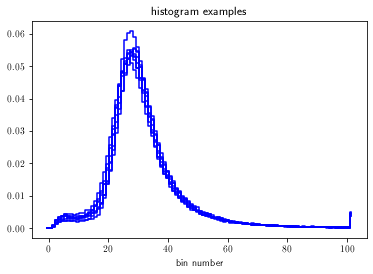


Histogram for chargeOuter_PXLayer_2


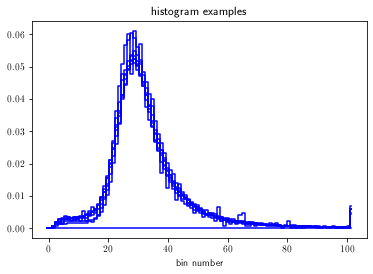


297598
Histogram for chargeInner_PXLayer_1


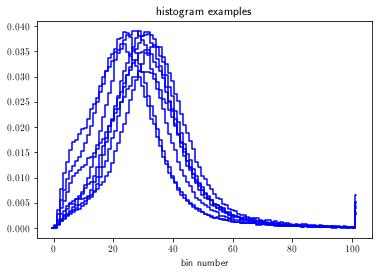


Histogram for chargeOuter_PXLayer_1


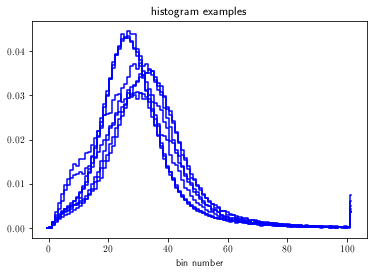


Histogram for chargeInner_PXLayer_2


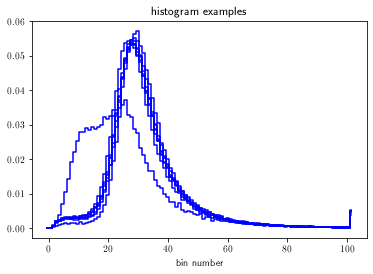


Histogram for chargeOuter_PXLayer_2


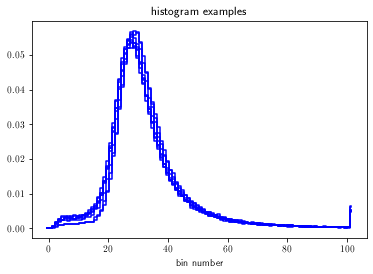


297604
Histogram for chargeInner_PXLayer_1


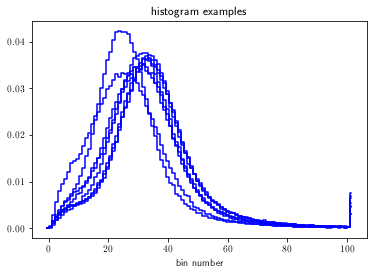


Histogram for chargeOuter_PXLayer_1


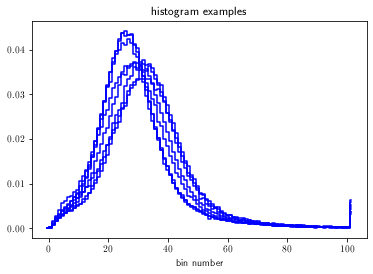


Histogram for chargeInner_PXLayer_2


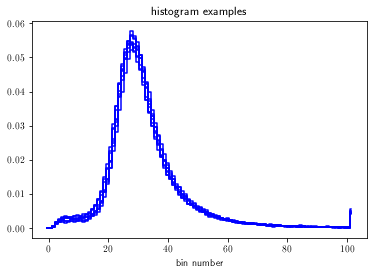


Histogram for chargeOuter_PXLayer_2


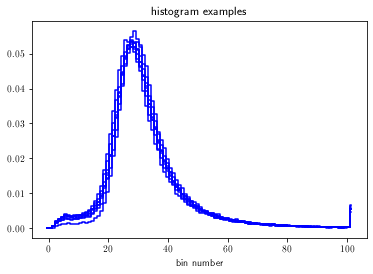


297620
Histogram for chargeInner_PXLayer_1


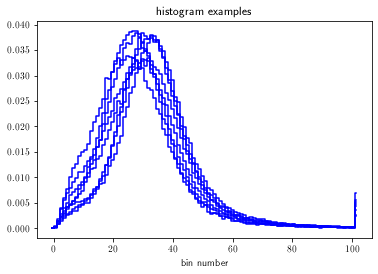


Histogram for chargeOuter_PXLayer_1


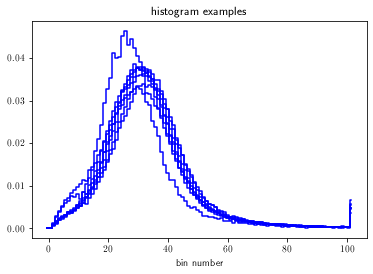


Histogram for chargeInner_PXLayer_2


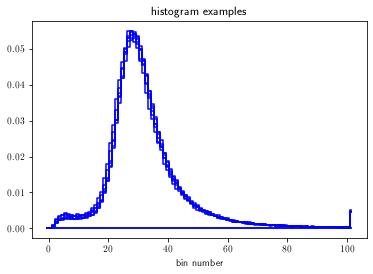


Histogram for chargeOuter_PXLayer_2


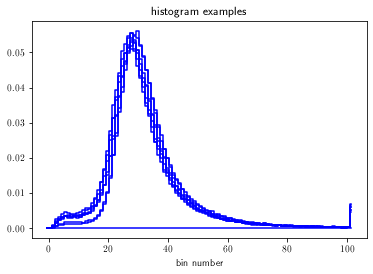


297659
Histogram for chargeInner_PXLayer_1


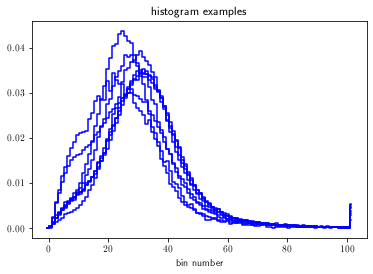


Histogram for chargeOuter_PXLayer_1


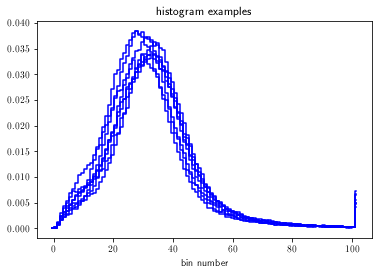


Histogram for chargeInner_PXLayer_2


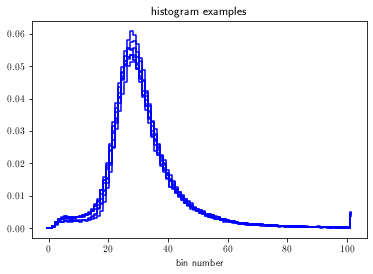


Histogram for chargeOuter_PXLayer_2


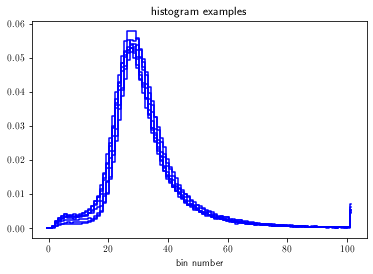


297670
Histogram for chargeInner_PXLayer_1


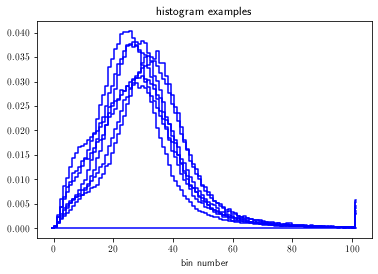


Histogram for chargeOuter_PXLayer_1


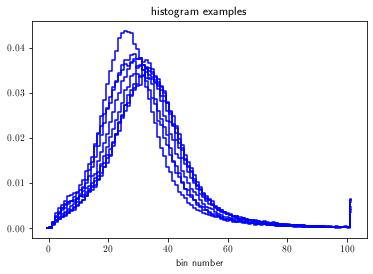


Histogram for chargeInner_PXLayer_2


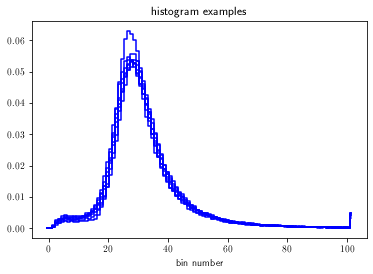


Histogram for chargeOuter_PXLayer_2


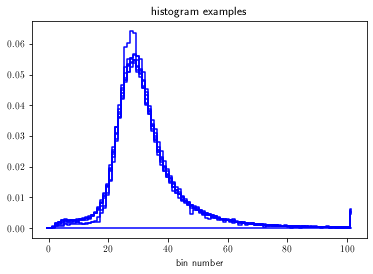


297674
Histogram for chargeInner_PXLayer_1


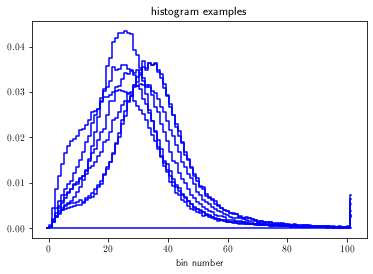


Histogram for chargeOuter_PXLayer_1


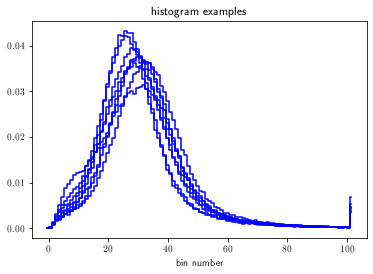


Histogram for chargeInner_PXLayer_2


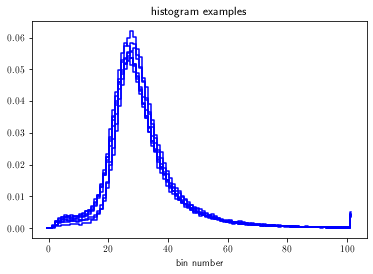


Histogram for chargeOuter_PXLayer_2


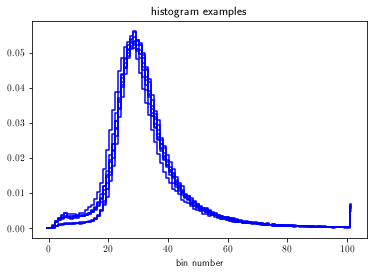


297678
Histogram for chargeInner_PXLayer_1


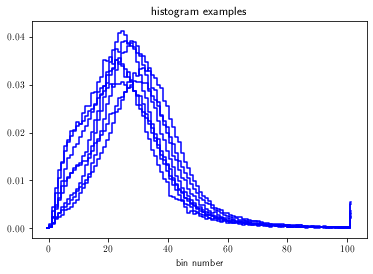


Histogram for chargeOuter_PXLayer_1


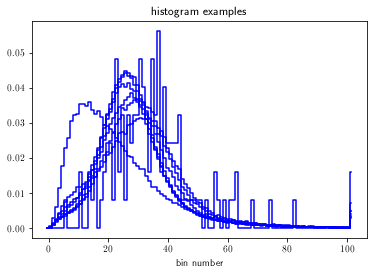


Histogram for chargeInner_PXLayer_2


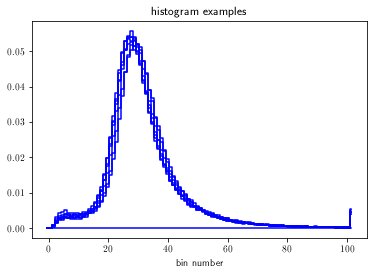


Histogram for chargeOuter_PXLayer_2


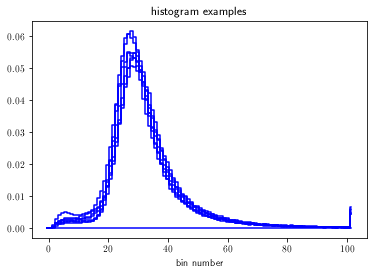


297722
Histogram for chargeInner_PXLayer_1


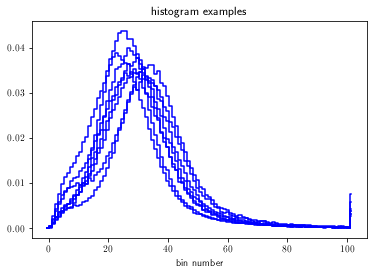


Histogram for chargeOuter_PXLayer_1


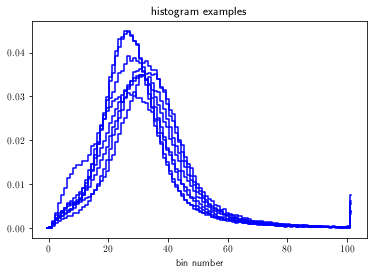


Histogram for chargeInner_PXLayer_2


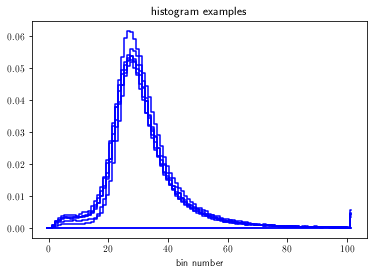


Histogram for chargeOuter_PXLayer_2


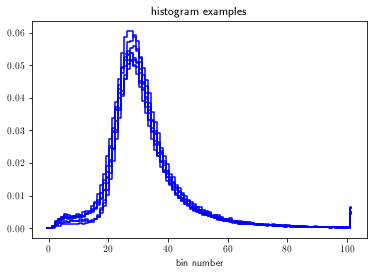


298997
Histogram for chargeInner_PXLayer_1


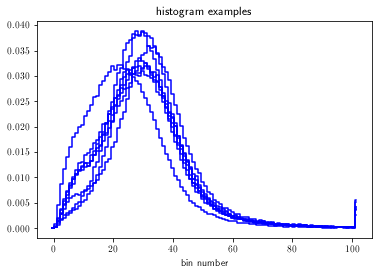


Histogram for chargeOuter_PXLayer_1


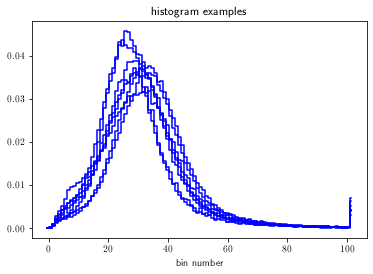


Histogram for chargeInner_PXLayer_2


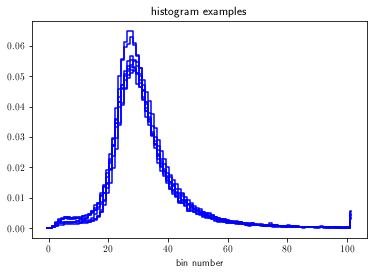


Histogram for chargeOuter_PXLayer_2


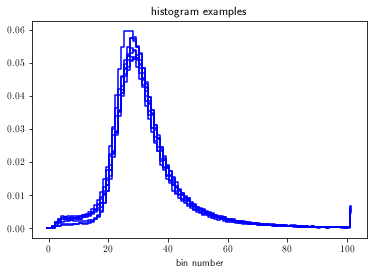


299061
Histogram for chargeInner_PXLayer_1


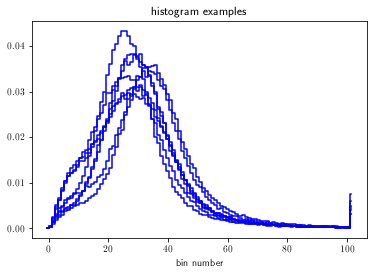


Histogram for chargeOuter_PXLayer_1


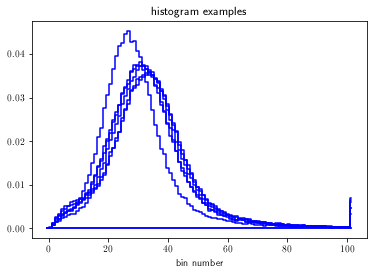


Histogram for chargeInner_PXLayer_2


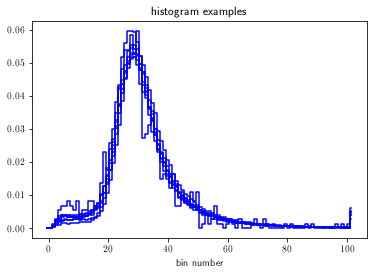


Histogram for chargeOuter_PXLayer_2


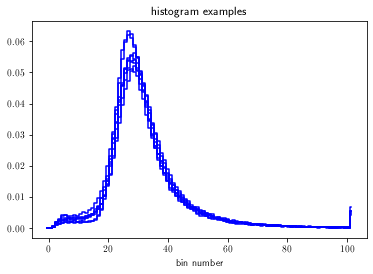


299065
Histogram for chargeInner_PXLayer_1


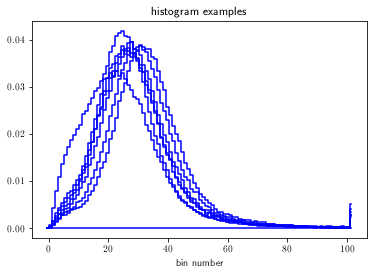


Histogram for chargeOuter_PXLayer_1


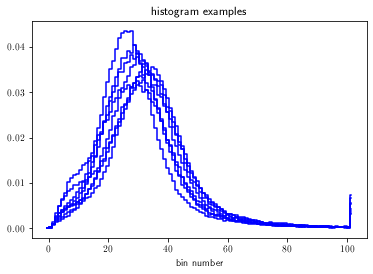


Histogram for chargeInner_PXLayer_2


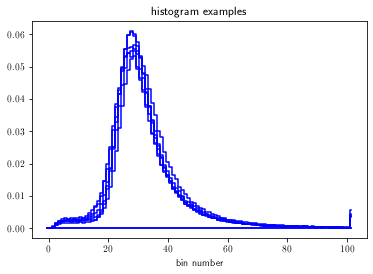


Histogram for chargeOuter_PXLayer_2


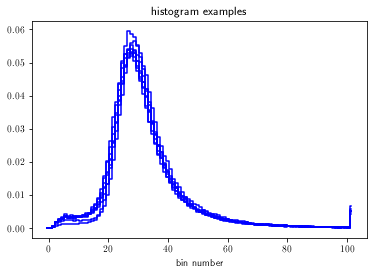


299067
Histogram for chargeInner_PXLayer_1


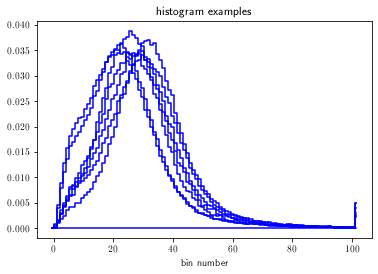


Histogram for chargeOuter_PXLayer_1


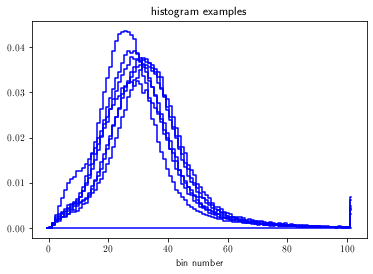


Histogram for chargeInner_PXLayer_2


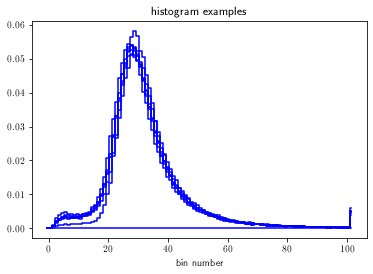


Histogram for chargeOuter_PXLayer_2


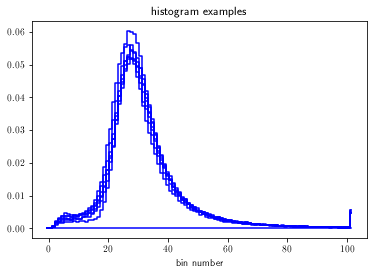


299096
Histogram for chargeInner_PXLayer_1


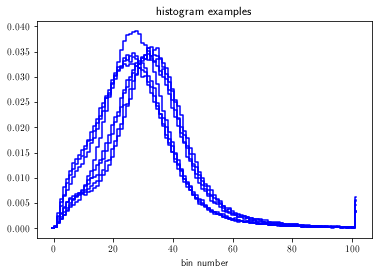


Histogram for chargeOuter_PXLayer_1


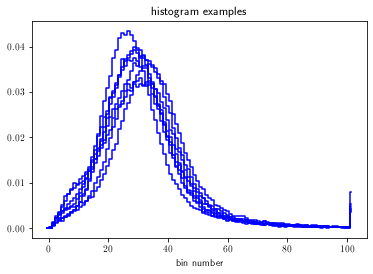


Histogram for chargeInner_PXLayer_2


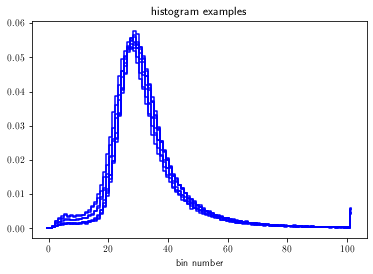


Histogram for chargeOuter_PXLayer_2


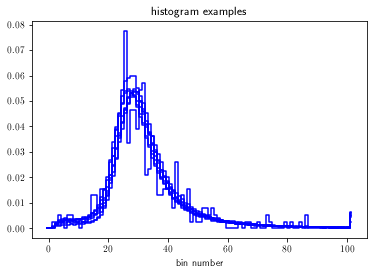


299149
Histogram for chargeInner_PXLayer_1


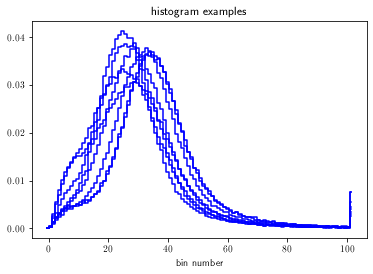


Histogram for chargeOuter_PXLayer_1


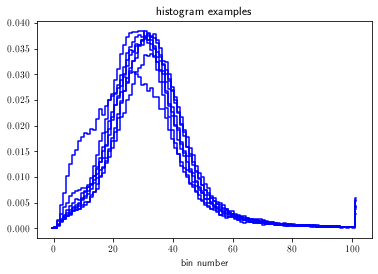


Histogram for chargeInner_PXLayer_2


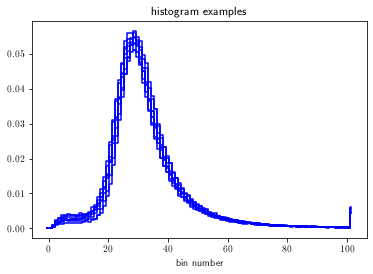


Histogram for chargeOuter_PXLayer_2


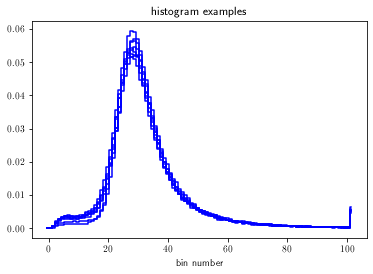


299178
Histogram for chargeInner_PXLayer_1


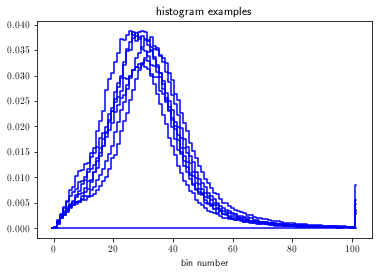


Histogram for chargeOuter_PXLayer_1


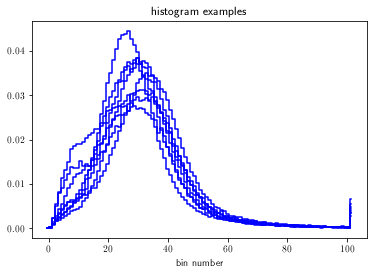


Histogram for chargeInner_PXLayer_2


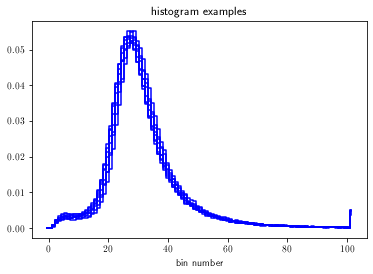


Histogram for chargeOuter_PXLayer_2


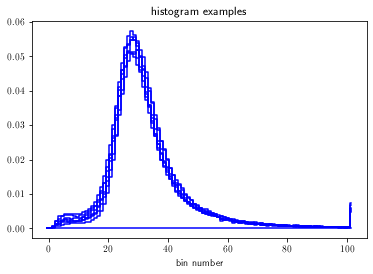


299184
Histogram for chargeInner_PXLayer_1


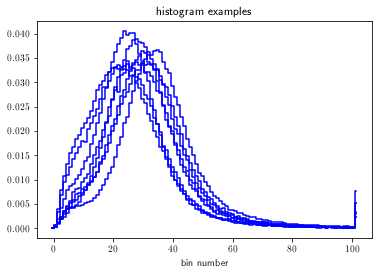


Histogram for chargeOuter_PXLayer_1


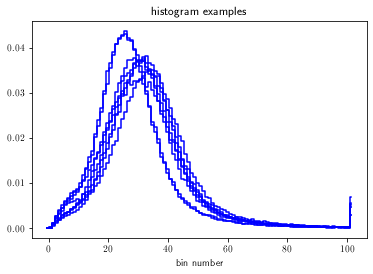


Histogram for chargeInner_PXLayer_2


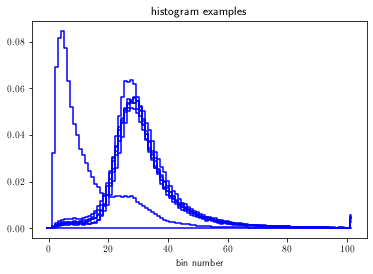


Histogram for chargeOuter_PXLayer_2


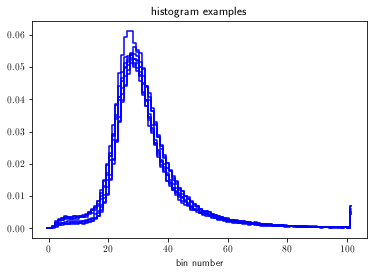


299185
Histogram for chargeInner_PXLayer_1


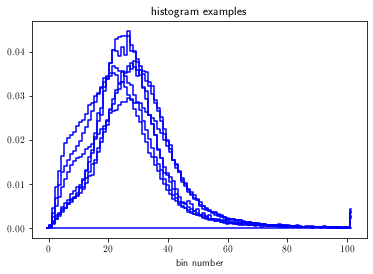


Histogram for chargeOuter_PXLayer_1


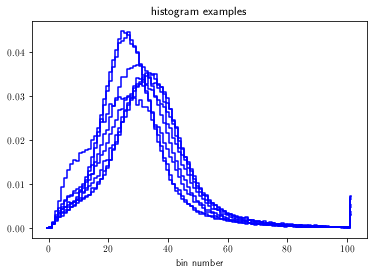


Histogram for chargeInner_PXLayer_2


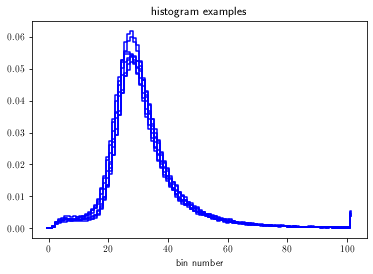


Histogram for chargeOuter_PXLayer_2


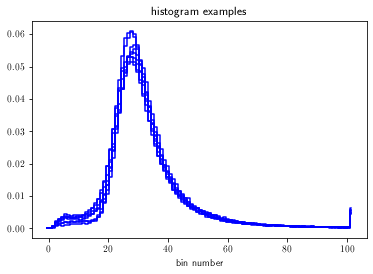


299327
Histogram for chargeInner_PXLayer_1


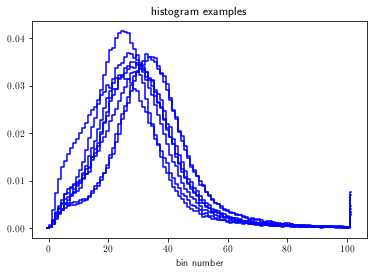


Histogram for chargeOuter_PXLayer_1


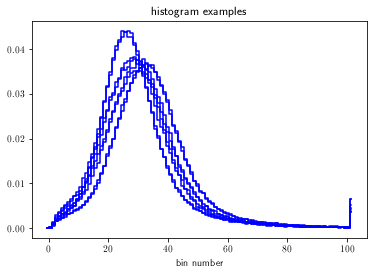


Histogram for chargeInner_PXLayer_2


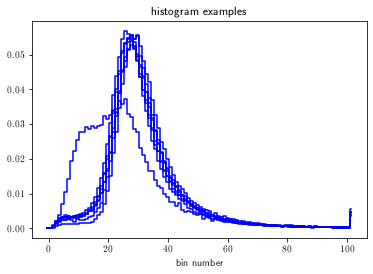


Histogram for chargeOuter_PXLayer_2


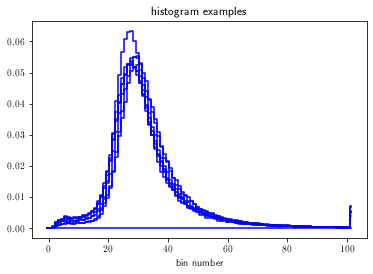


299329
Histogram for chargeInner_PXLayer_1


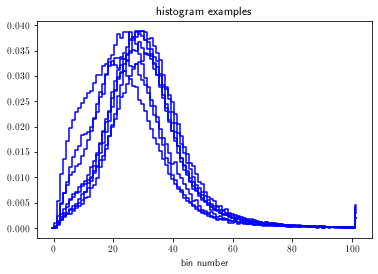


Histogram for chargeOuter_PXLayer_1


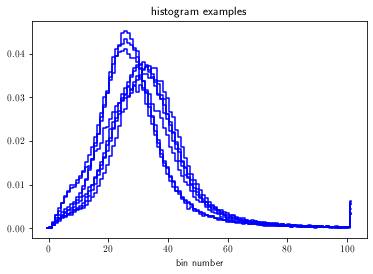


Histogram for chargeInner_PXLayer_2


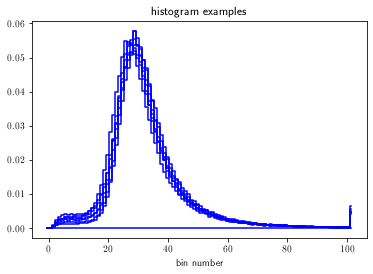


Histogram for chargeOuter_PXLayer_2


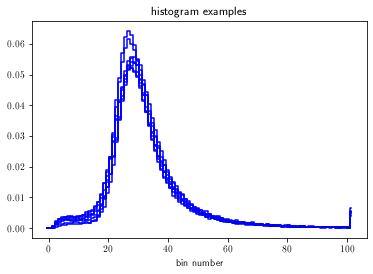


299480
Histogram for chargeInner_PXLayer_1


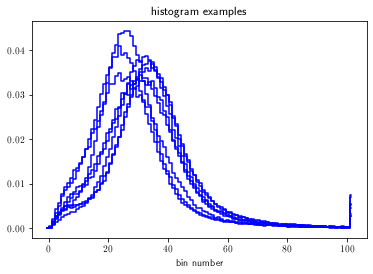


Histogram for chargeOuter_PXLayer_1


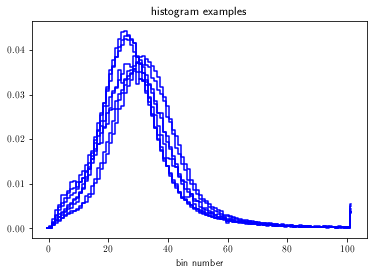


Histogram for chargeInner_PXLayer_2


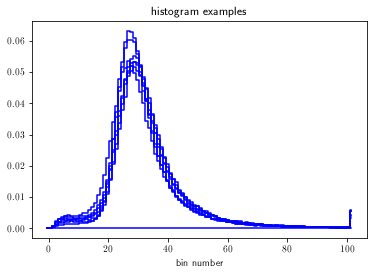


Histogram for chargeOuter_PXLayer_2


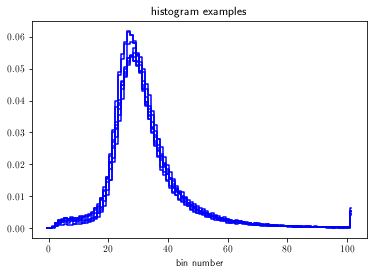

In [16]:
for run in trainrunsls['2017']:
    
    print(run)
    
    dloader = DataLoader.DataLoader()
    
    for histgroup in histnames:
        for histname in histgroup:
            filename = '../data/DF'+year+'B_'+histname+'.csv'
            df = dloader.get_dataframe_from_file( filename )
            
            print('Histogram for ' + histname)
            hu.preparedatafromdf(df, rebinningfactor = 1, doplot = True, donormalize = True)
            plt.show()
            print()